# Narwhal

This is a notebook containing all the code used for analysis of results for my first results chapter and the corresponding paper.

This notebook contains only the code for final versions of analysis and plotting - anything else that was written in development but not ultimately used in the final versions can be found in the Narwhal_oldversion notebook.

## Functionality
* Dataset descriptions (Icelandic and Kenyan datasets)
* Dataset comparisons (sampling, disease types, serotype composition)
* Bacteriocin presence/absence in each dataset
* Patterns of bacteriocin partial/full clusters
* Differences in bacteriocins Iceland/Kenya, pre/post vac, carriage/disease (chisq)
* Associations of the bacteriocins with genetic lineages
* Bacteriocin repertoires - most frequent in both datasets and variability within genetic lineages 


* **To do: take function definitions out to a .py document, and call the functions which generate results here with notation**

## Version control workflow

* Using version control in github to backup code in this notebook
* Using the notebook directly is not very effective for version control because the cell outputs and other metadata get in the way of diffs - identical code would register as different
* Jupytext - this notebook is paired to a text file (percent script format) which is stored as Narwhal.py in the same directory as the notebook
* The text file, rather than the notebook file, is used for version control with standard git commands on the command line
* Initialized as a private repo for the time being, with the intention of making the repo public with proper documentation at time of publication

**This version is the cleanup branch - for improving code** 




___

## Setup

* Imports should be BIGSdb curated database exports with all metadata, MLST loci, CCs and bacteriocin loci
* This section also defining some key functions such as Odds Ratio calculation and output for plotting
* Make sure that you are in the conda baseenv environment - ported over from the base environment on the last laptop July 2021


___

### Importing libraries

* Vaccination year defines the post-vaccination period. Both countries started using PCV10 in 2011, so 2012 onwards is the "post-vaccination" period.
* Set to give all values from calculations to 3 decimal places.
* Setting up seaborn styles here too, although these are manually adjusted in most figures



In [1]:
### will be able to delete these as they are imported with processing.py
#import sys
#import os
#import math
#from pandas import Series, DataFrame

#import numpy as np



#import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
#import matplotlib.patches as mpatches
#import matplotlib.lines as mlines
#import matplotlib.ticker as ticker
#from matplotlib.ticker import MultipleLocator

import pandas as pd
from datetime import date
import seaborn as sns
from importlib import reload 

## this is the file with all the processing functions
import processing

## this is the file with the analysis and plotting functions 
import analysis 

# and maybe removing some of the extra bits of setup below here 
sns.set_palette("colorblind")
sns.set(style="whitegrid")

# getting in a date for saving exports
today = date.today()
d1 = today.strftime("%Y%m%d")

# setting the precision on pandas for this notebook 
pd.set_option("precision", 3)

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


___ 

# Dataset Import and Processing 

* A single function is used to import the BIGSdb dataset export and to process it ready for analysis 

___

## Set input file location

* Define the variable input_file as the location of a suitable BIGSdb dataset export 
* This will the file that is read in, checked, processed, analysed and visualised for all results 

In [2]:
input_file = "./inputs/combined_export.csv"

___

## Set vaccine year 

* For the Icelandic and Kenyan datasets this is 2012 - everything before 2012 is pre-vaccination, everything after (including 2012) is post-vaccination 
* This can be changed by adjusting this variable if required 

In [3]:
vac_year = 2012


___

## Processing

#### Various processing steps are performed here, including:

* Checking that the imported data is in the expected format and contains bacteriocin locus designations 
* Adjusting the data type of the allele designations to strings (often recognised as integers, which breaks downstream processing)
* Renames columns to remove names with spaces 
* Defines the vaccine period (pre or post) for each isolate based on the year of sampling relative to the vac_year global variable 
* For disease isolates, defines a disease category based on the source field (otitis media (OM): from middle ear fluid, lower respiratory tract infection (LRT): from sputum or lung aspirate, invasive (IPD): from sterile sites)
* Locus column order adjusted to reflect the order of the loci within genomes (rather than the default alphabetical)

#### Bacteriocin profile and category columns 
* BacteriocinProfile class is used to store information about each bacteriocin cluster in each isolate
* allelic_profile - the combination of alleles at each locus of a bacteriocin cluster in a given genome
* partfull_profile - as for allelic profile, but simple describes whether the locus is present or absent rather than the detected allele
* category - whether the cluster is full (Fl, all expected loci detected), partial (P, more than half the expected loci detected), fragment (Fg, less than half of the expected loci detected), or absent (A, no loci of the cluster detected)
* status - whether the cluster is counted as "present" (True) or "absent" (False). Full and partial clusters counted as present, all others counted as absent 
* For more detail please see relevant sections of processing.py file, where the BacteriocinProfile class is defined 
* Information stored in the BacteriocinProfile instances are used to generate columns for each bacteriocin in the datasets describing its allelic profile and category in each genome 

#### Bacteriocin status columns 
* Status columns describe simply whether a bacteriocin is present or absent in each genome of the dataset 
* This section incorporates an assessment of cluster contiguity - uses an output from a separate script: contiguity_cat.py 
* contiguity_cat.oy is run on the command line and uses gbk-like annotated sequence files (exported from bigs using bigs_genbankerator.py) to get the seqeunce coordinates of each allele designation and to assess whether the loci of the cluster are found andjacent to each other within each genome 
* Default thresholds: adjacent loci must be within 2.5kbp of each other to be classed as contiguous, if the cluster is interrupted by a contig break then the loci must be within 2.5kbp of the end of both contigs to be classed as likely contiguous across a contig break 
* For more details on categorisation see main text of the paper or contiguity_cat.py 
* Status uses the status attribute of the BacteriocinProfile class and then checks that the cluster is contiguous. If it is not contiguous, the status is False and the non-contiguous cluster is not included in downstream analysis. 

#### Further bacteriocin analysis columns 
* Cluster count uses the status columns to generate a count of how many different bacteriocin clusters were detected in a single genome 
* Each bacteriocin cluster is counted a single time 
* Bacteriocin repertoire is a description of the combination of bacteriocins that are present in each genome, again based on the status columns 
* This is not very human readable but is used for figure generation 



In [4]:
df = processing.process(input_file, vac_year)

Reading in file: ./inputs/combined_export.csv
Required columns found in df
Found bacteriocin loci - continuing with processing
Imported and checked data
Adjusted data type of allele designations to string
Renamed columns
Defined pre/post vaccine periods based on year of sampling
Defined disease type based on source field
Adjusted locus order in curated data export to reflect order found in reference clusters
Generated profile and category columns for cib
Generated profile and category columns for sca
Generated profile and category columns for scb
Generated profile and category columns for scc
Generated profile and category columns for scd
Generated profile and category columns for sce
Generated profile and category columns for scy
Generated profile and category columns for sla
Generated profile and category columns for slb
Generated profile and category columns for slc
Generated profile and category columns for sld
Generated profile and category columns for sle
Generated profile and ca

___
___

# Analysis 

* Various analysis functions defined in analysis.py 
* These include functions to summarise data, to output tables and to plot data as figures 
* This section is organised according to figure number 
* Outputs are saved into an output directory in the same location as this notebook and named according to the figure number and date. If exported multiple times on the same date, export files will be overwrtten. 


___
___
## Dataset summaries 

* Generating tables and figures which describe the composition of the Icelandic and Kenyan datasets 
* Table 1: summary of the number of genomes in each dataset from various categories. Includes a count of unique STs/CCs/singletons/serotypes 
* Table 2: the most common CCs in the two datasets. Generated here as two tables (one for each dataset) which are exported as csvs joined and formatted in Excel/Word.
* Table 3: as for table 2, for serotypes rather than CCs. 
* Figure 1A: frequency distribution of the sampling year for both datasets, stacked bars showing the proportion of genomes in each year recovered from carriage or disease type. 
* Figure 1B: frequency distribution of the age of patient pneumococci were recovered from in each dataset, again stacked bars for carriage/disease type.

___
### Table 1 - Dataset Summary

* summary_table generates a dataframe summarising various things from both datasets 
* The version in the paper does not include all of these fields - modified and formatted in Word, but numerical values unchanged from those generated here 

In [11]:
analysis.summary_table(df)

,Iceland,Kenya
Total,1912,3159
Carriage,983,2387
Disease,929,772
Invasive,183,772
LRTI,283,0
Otitis media,463,0
Pre-vaccination,1039,1660
Post-vaccination,873,1499
Male,1028,1593
Female,883,1566


___

### Shared CCs and STs

* Not saving an output - this just gives numbers of how many CCs and STs are found in both datasets 
* Function which returns text describing how many CCs and STs are found in both datasets and how many are shared
* For describing how different the Icelandic and Kenyan populations are

In [12]:
analysis.shared_CCs(df)

Iceland:
64
Kenya:
178


18

In [13]:
analysis.shared_STs(df)

Iceland:
162
Kenya:
547


5

___
### Table 2 - Common Lineages

* Two tables showing the most common lineages (CCs and singletons) in each dataset (Iceland and Kenya) 
* Number of common lineages determined by the threshold argument in the cc_freq_proc() function 
* These tables are exported as separate csvs and joined and formatted manually in Excel/Word, but numerical values not altered. 

In [14]:
analysis.cc_freq_proc(df[df.country == "Iceland"], 20)

,CC,n (%)
0,236/271/320,293 (15.3%)
1,439,217 (11.3%)
2,199,179 (9.4%)
3,138/176,122 (6.4%)
4,180,107 (5.6%)
5,62,94 (4.9%)
6,97,87 (4.6%)
7,490,74 (3.9%)
8,124,62 (3.2%)
9,433,61 (3.2%)


In [15]:
analysis.cc_freq_proc(df[df.country == "Kenya"], 20)

,CC,n (%)
0,5902,239 (7.6%)
1,217,223 (7.1%)
2,701,163 (5.2%)
3,5339,142 (4.5%)
4,1146,139 (4.4%)
5,138/176,133 (4.2%)
6,156/162,131 (4.1%)
7,991,104 (3.3%)
8,230,92 (2.9%)
9,852,78 (2.5%)


___
### Table 3 - Common Serotypes

* Two tables showing the most common serotypes in each dataset 
* As for Table 2, can adjust the threshold of how many serotypes detailed in the tables 
* Again tables are exported as csvs and joined manually in Excel/Word, numerical values as generated here.

In [16]:
analysis.serotype_freq_proc(df[df.country == "Iceland"], 20)#.to_csv("./TopSerotypes_Iceland.csv")

,Serotype,n (%)
0,19F,331 (17.3%)
1,23F,180 (9.4%)
2,6A,163 (8.5%)
3,19A,145 (7.6%)
4,6B,122 (6.4%)
5,3,109 (5.7%)
6,15BC,93 (4.9%)
7,11A,93 (4.9%)
8,14,90 (4.7%)
9,NT,70 (3.7%)


In [17]:
analysis.serotype_freq_proc(df[df.country == "Kenya"], 20)#.to_csv("./TopSerotypes_Kenya.csv")

,Serotype,n (%)
0,19F,228 (7.2%)
1,1,224 (7.1%)
2,6A,206 (6.5%)
3,19A,153 (4.8%)
4,15BC,146 (4.6%)
5,35B,139 (4.4%)
6,15A,136 (4.3%)
7,14,131 (4.1%)
8,6E(6B),131 (4.1%)
9,23F,119 (3.8%)


___
### Figure 1A - Distribution of Pneumococci by Year of Isolation 

* Showing the sampling year of each pneumococci in the two datasets (two panels).
* Dashed line indicating vaccine year

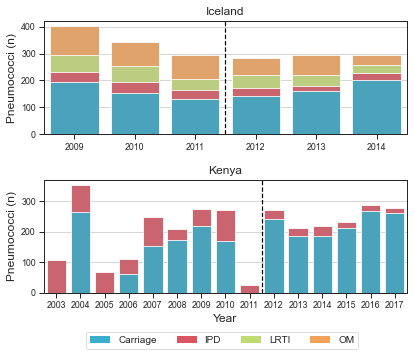

In [18]:
analysis.stack_year_plot(df)

___
### Figure 1B - Distribution of Age Groups 

* Showing the age groups pneumococci were sampled from in each dataset. 
* Age groups are 0 - 5, 5 - 9.9 and then in 10 year increments. 


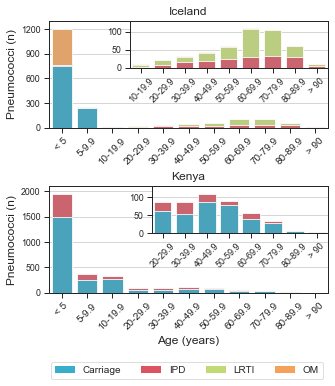

In [19]:
analysis.age_plot(df)

___

### Additional Figure - Serotype Distribution 

* This figure is for thesis chapter 3 but is not included in the paper manuscript - this section and the accompanying code in analysis.py should be removed before this code is published 
* Raises various SettingWithCopy warnings that can be ignored, ugly output 

/opt/anaconda3/envs/baseenv/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:3365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf["stack_count"] = stack_count
/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:3366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

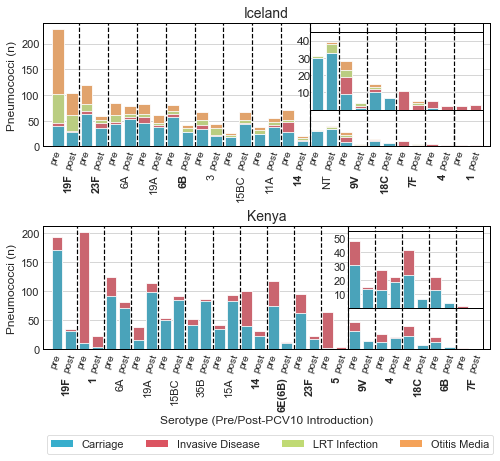

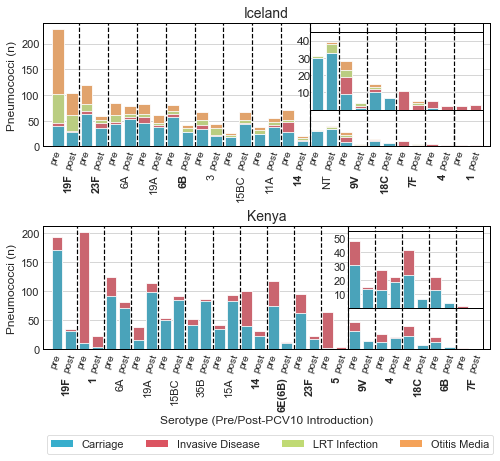

In [20]:
analysis.stacked_serotype(df)

#### Description of data not included in serotype plot 

* Descriptive text output showing how many serotypes and isolates are not represented on the above plot
* To be reported in the figre legend 

In [21]:
analysis.seroplot_breakdown(df)

Iceland:
Number of serotypes included in plot:
15
Number of isolates represented in plot:
1396
Number of serotypes not included in plot:
25
Number of isolates not represented in plot:
516
____

Kenya:
Number of serotypes included in plot:
16
Number of isolates represented in plot:
1613
Number of serotypes not included in plot:
40
Number of isolates not represented in plot:
1546


___
___
## Bacteriocin Prevalence 

* Generating a figure (Figure 2A) and supplementary table (Supplementary Table 5) showing the overall prevalence of the bacteriocin clusters 
* Also shows which bacteriocins are significantly more or less common in each dataset 
* Tables 2 and 3 show streptolancidin A and B distribution in clonal complexes (CCs) of each dataset
* Supplementary Table 7 is the same analysis but for all the streptolancidins which show significant differences between the two datasets 


___ 
### Supplementary Table 5 - Bacteriocin Prevalence and Partial Cluster Compositions 

* A table showing the prevalence of full and partial clusters of each bacteriocin in the two datasets and also the locus compositions of any partial clusters observed
* Version in the manuscript re-organised and formatted using Excel 


In [22]:
analysis.supp_table_5_6(df)

,Bacteriocin,Country,Profile,Category,Frequency
0,cib,Kenya,A-B-C,Full,3159
1,cib,Iceland,A-B-C,Full,1895
2,cib,Iceland,/-/-C,Fragment,17
3,sca,Kenya,A-B-C,Full,2562
4,sca,Iceland,A-B-C,Full,1537
...,...,...,...,...,...
63,slk,Iceland,A-L-T,Full,2
64,slk,Iceland,/-/-T,Fragment,5
65,sls,Kenya,A-C-B1-B2-F-E-G-R-K,Full,77
66,sls,Iceland,A-C-B1-B2-F-E-G-R-K,Full,48


___
### Figure 2A - Bacteriocin Prevalence 

* Stacked bars - showing the proportion of clusters that are partial and full 
* Partial clusters defined during processing with the BacteriocinProfile class 

/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:966: UserWarning: FixedFormatter should only be used together with FixedLocator
  prev_plot.ax.set_yticklabels(prev_plot.ax.get_yticklabels(), fontsize=12)


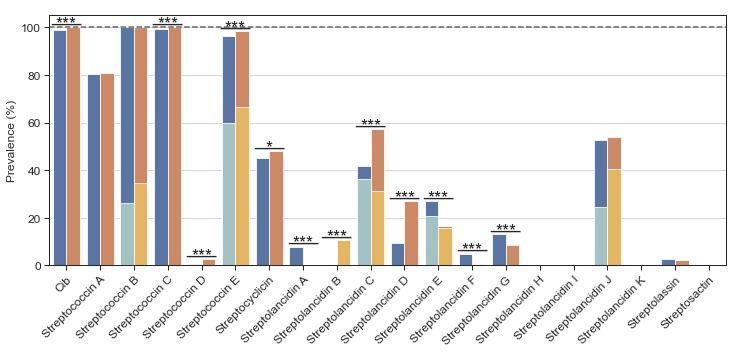

In [24]:
analysis.grouped_prev_bar(df)

___
___

## Differences in Bacteriocin Prevalence 

* Analysing which bacteriocins show significant differences in prevalence in the pre/post PCV10 time-period and in carriage/disease genomes 
* Plotting scatter plots to visualise the differences 
* Figures 2B and 2C 
___

### Figure 2B - Differences in Post-PCV10 Time Period

* A scatter plot of the difference in overall prevalence of each bacteriocin in the post-PCV10 time period compared to the pre-PCV10 time period, split out by dataset
* Point shapes and colour indicate which differences are statistically significant according to a chi-square test 
* Generates some warnings which can be ignored 
* Legend generated in Affinity Designer because it is too complicated to do efficiently in python 
* X axis order manually defined within the plotting function 

/opt/anaconda3/envs/baseenv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:1237: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticks(), size = 12)


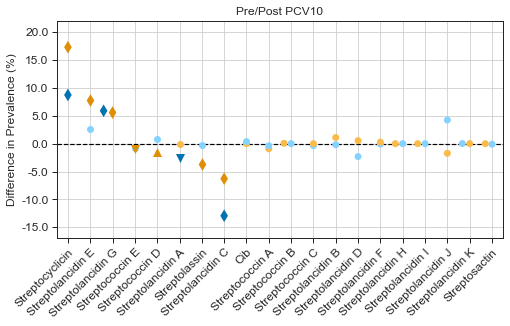

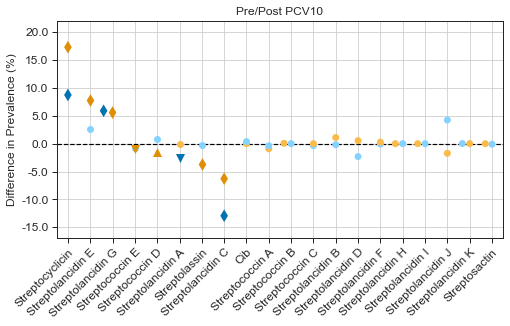

In [25]:
analysis.scatter_vac(df)

___
### Figure 2C - Differences in Carriage vs. Disease Pneumococci

* Comparing the various disease categories separately - invasive, lower respiratory tract and otitis media 
* One axis for each disease process
* The LRTI and OM axes will have only Icelandic data at these were not sampled in the Kenyan dataset 
* X axis order set manually according to magnitude of changes when carriage/IPD compared, the same for all the panels for ease of comparison of the same bacteriocin at different conditions 

/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:1537: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_yticks(), size = 12)


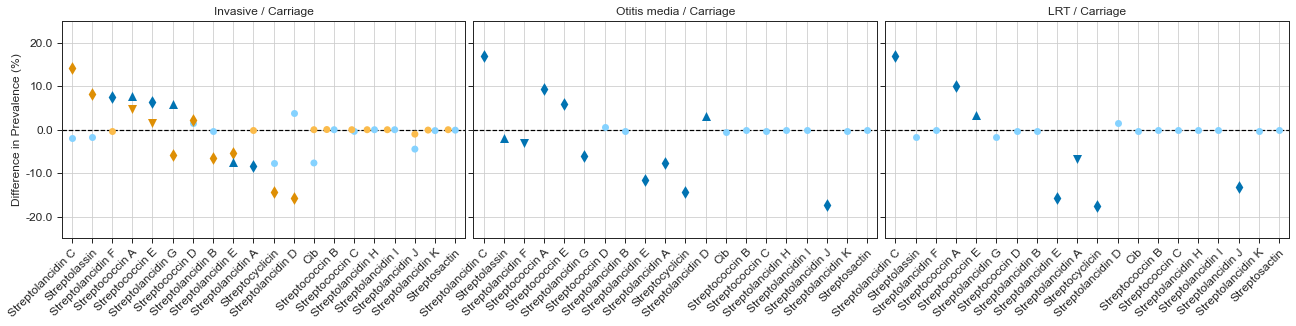

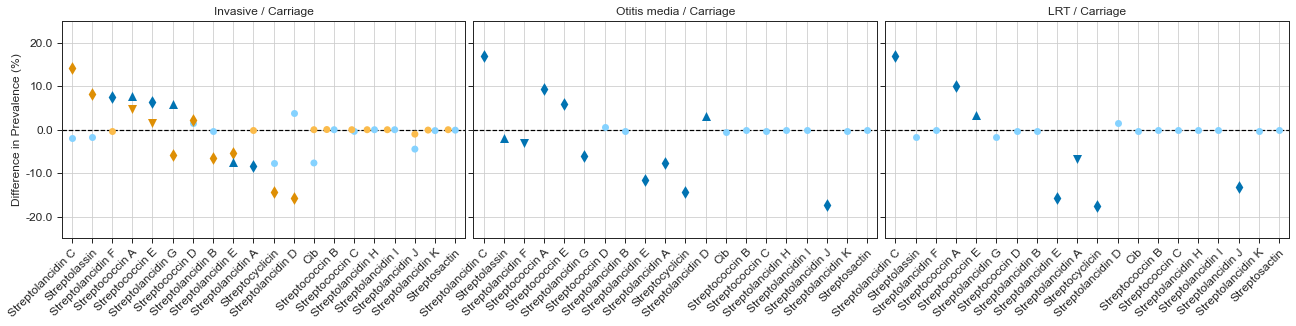

In [26]:
analysis.scatter_dis_panel(df, "")

___
___
## Bacteriocin/Lineage associations 

* Looking at the distribution of the bacteriocin clusters in genetic lineages defined in the Icelandic and Kenyan datasets in order to explain the differences in prevalence shown above 
* Comparing lineages between datasets, in the pre/post PCV10 time periods and in carriage/disease pneumococci 
* Data presented in tables and figures 
___
### Table 5 - Streptolancidin B Lineage Associations 
### Supplementary Table 7 - Streptolancidin Lineage Associations 

* Showing the associations of bacteriocins which are significantly different in the two datasets with lineages (clonal complexes) 
* Demonstrating that differences in the population structures account for differences in bacteriocin prevalence 
* Function below generates a table for each bacteriocin in the dataset, which can then be manually joined and formatted as seen in the paper using Excel/Word 
* This function will return all the tables and only save them out if an output directory argument (as a string) is given 

In [27]:
analysis.location_cc_assocations(df)

#analysis.location_cc_assocations(df, (output_dir + "bacteriocin_lineage_tables/dataset/" + d1 + "_"))

No output directory given, printing dataframes for all bacteriocins
                           d1          d2
CC                                       
CC236/271/320       293 (100)     4 (100)
CC138/176           122 (100)   133 (100)
CC5902                      0   239 (100)
CC217                       0   223 (100)
CC439               217 (100)           0
CC199               179 (100)           0
CC156/162            46 (100)   131 (100)
CC701                       0   163 (100)
CC5339                      0   142 (100)
CC1146                      0   139 (100)
Other CCs         1022 (99.9)  1840 (100)
Other Singletons     16 (100)   145 (100)
                          d1           d2
CC                                       
CC236/271/320     286 (97.6)            0
CC138/176         121 (99.2)   130 (97.7)
CC5902                     0   236 (98.7)
CC217                      0   222 (99.6)
CC439             184 (84.8)            0
CC156/162           46 (100)    131 (100)
CC701   

___
### Figure 3 - Lineage Distribution of Streptolancidin C and Streptocyclicin pre/post PCV10 and Carriage/Disease

* Stacked bar charts showing CCs in which each bacteriocin was found, and what proportion of each lineage had the bacteriocin, split by pre/post PCV10 time period and by carriage/disease.
* The dominant serotype of each CC is shown with the lineage name. Where the top serotype corresponds to < 50% of the genomes of that lineage, the second highest serotype also shown. 
* Any CC representing < 1% of the overall dataset (Iceland or Kenya) is binned to the "other" category.
* On the Icelandic disease panels, only cases where the bacteriocin was significantly altered are shown, so for both plots IPD isolates are excluded as the two bacteriocins were not significantly more or less common in genomes from IPD relative to carriage. 
* Very complicated plotting functions for this figure - separate plotting functions for pre/post vac, Kenyan carriage/IPD and Icelandic carriage/disease bar plotting.
* Legends added in Affinity designer by hand.
* Also CCs with dominant serotypes which are included in PCV10 made bold in Affinity Designer 

#### Figure 3A - Streptolancidin C 

/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:2419: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0, 0, 5, 10, 15])


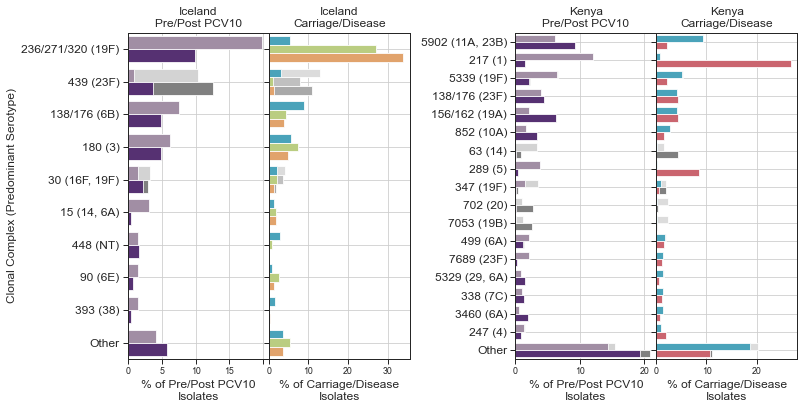

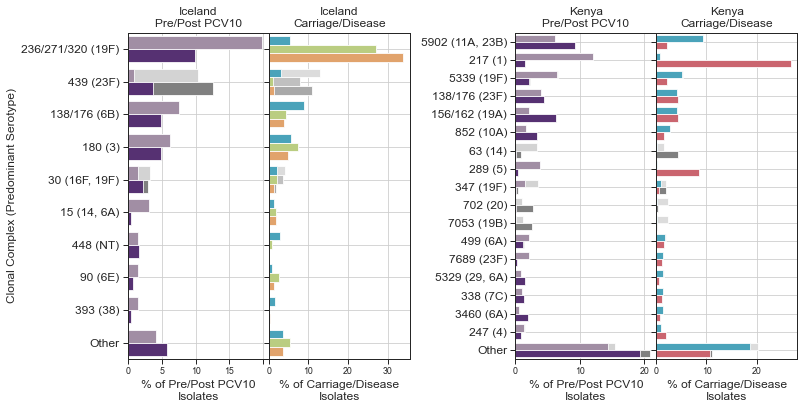

In [28]:
analysis.slc_panel(df)

#### Figure 3B - Streptocyclicin

/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:2471: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels([0, 5, 10])


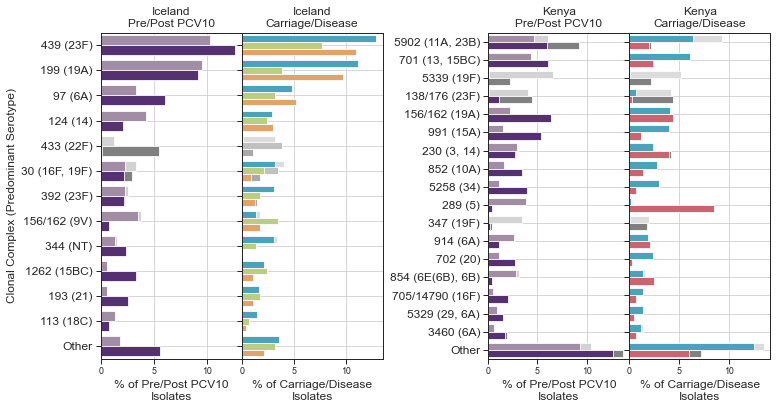

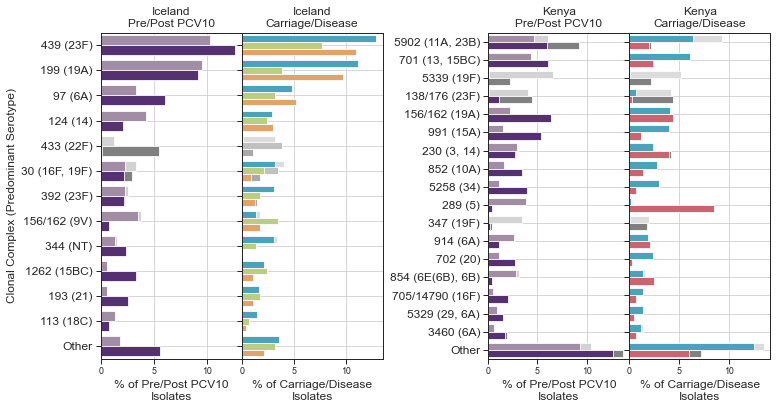

In [29]:
analysis.scy_panel(df)

### Supplementary Tables 8 and 9 - Bacteriocin/Lineage Associations in Pre/Post PCV10 and Carriage/Disease Pneumococci

* Tables showing the data plotted in Figure 3 for all the bacteriocins that showed significant differences in prevalence in subsets of the two datasets.
* Two tables - Supplementary Table 8 shows all significantly altered bacteriocins in the Icelandic dataset, Supplementary Table 9 shows all significantly altered bacteriocins in the Kenyan dataset.
* Data are generated here, saved as csvs and formatted in Excel. These tables remain in Excel format (rather than Word) because they are very long. 
* Tables show the 10 most common CCs in which each bacteriocin is found, all others are grouped to the "other" bin, and the prevalence of each lineage in subsets of the data is shown as a raw count and as a proportion of the genomes in that subset. 
* Additionally, the number of genomes of each lineage to have the bacteriocin is given. 
* The output function here saves a csv of the lineage associations of every bacteriocin in each dataset - user needs to manually choose which ones are to be included in the final merged tables for the paper. 


In [31]:

#analysis.bacteriocin_cc_table_combo_outputs(df, "Iceland", (output_dir + "bacteriocin_lineage_tables/vaccination_disease/" + d1)) 
#analysis.bacteriocin_cc_table_combo_outputs(df, "Kenya", (output_dir + "bacteriocin_lineage_tables/vaccination_disease/" + d1)) 

### Supplementary Tables 10 and 11: Bacteriocin/Serotype associations in Icelandic and Kenyan datasets 

* These functions save a csv for each bacteriocin cluster in each dataset showing the association of the bacteriocin clusters with serotypes, as above for CC associations. 
* As above, the user can use whichever are required for the text and manually put them together in Excel 

In [32]:

#analysis.bacteriocin_serotype_table_outputs(df[df.country == "Iceland"], (output_dir + "bacteriocin_serotype_tables/" + d1 + "_Iceland"))
#analysis.bacteriocin_serotype_table_outputs(df[df.country == "Kenya"], (output_dir + "bacteriocin_serotype_tables/" + d1 + "_Kenya"))

___
___
## Number and Combination of Bacteriocins per Genome 

* Looking at how many bacteriocins, and what combination of bacteriocins, can be found in each genome from the two datasets 
* Combinations of bacteriocins are termed "repertoires" 
___

### Figure 4A: Cluster count 

* Frequency distribution of the number of bacteriocin clusters per genome 
* Bars coloured by dataset 

/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:2681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=12)


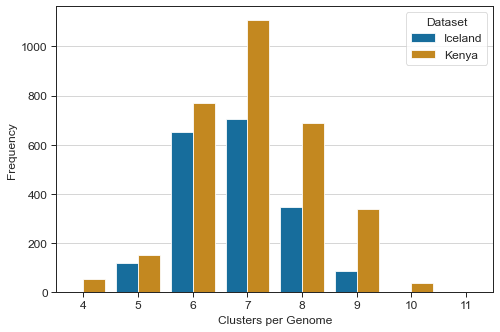

In [33]:

analysis.cluster_count_bar(df)

___ 
### Figure 4B: Most common bacteriocin repertoires

* Which combination of bacteriocins is most commonly seen in the two datasets? 
* Showing this using a heatmap 

(<Figure size 576x144 with 1 Axes>, <Figure size 576x144 with 1 Axes>)

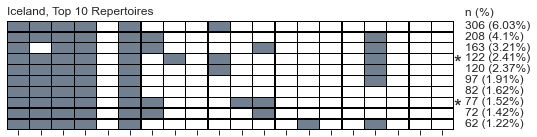

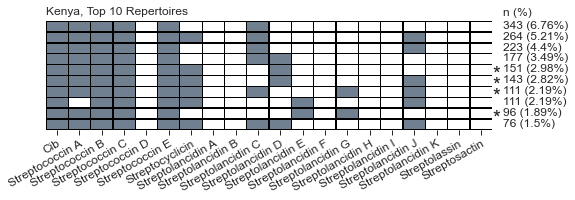

In [34]:

analysis.top10rep_hm(df)

___
### Figure 4C/4D: Repertoires within CCs and STs

* Functions generate loads of heatmaps that need to be stitched together into multi-panel figures 
* Generating heatmaps for examples of CCs with multiple repertoires and selected STs from within those CCs 


#### Text description of CCs with mixed repertoires 

* Returns the number of CCs with >1 repertoire
* To print a list of the CCs, call analysis.mixed_rep_cc(df)

In [35]:
analysis.cc_repertoires(df)

Iceland

Number of clonal complexes with mixed bacteriocin repertoires:
29

Kenya

Number of clonal complexes with mixed bacteriocin repertoires:
61


#### Supplementary Table describing the CCs with multiple repertoires 

* Slow function generating a table of all CCs with multiple repertoires in the given dataset, and the bacteriocins that varied
* Also includes columns describing whether any STs within the CC had mixed repertoies 

In [36]:
analysis.lineage_rep_table(df[df.country == "Iceland"])

,CC,Variable bacteriocins (CC),Mixed STs,Variable bacteriocins (ST)
0,236/271/320,"Streptococcin A, Streptococcin E",271,Streptococcin E
1,236/271/320,"Streptococcin A, Streptococcin E",1968,Streptococcin A
2,439,"Streptococcin A, Streptolancidin C, Streptolan...",311,Streptococcin A
3,439,"Streptococcin A, Streptolancidin C, Streptolan...",507,Streptococcin A
4,439,"Streptococcin A, Streptolancidin C, Streptolan...",442,Streptococcin A
5,439,"Streptococcin A, Streptolancidin C, Streptolan...",190,Streptococcin A
6,199,"Streptolancidin E, Streptolancidin J, Streptos...",199,"Streptolancidin E, Streptolancidin J, Streptos..."
7,138/176,Streptococcin A,176,Streptococcin A
8,180,Streptococcin A,180,Streptococcin A
9,62,"Streptococcin A, Streptolancidin J",62,Streptolancidin J


In [37]:
analysis.lineage_rep_table(df[df.country == "Kenya"])

,CC,Variable bacteriocins (CC),Mixed STs,Variable bacteriocins (ST)
0,5902,"Streptococcin A, Streptocyclicin, Streptolanci...",5902,"Streptocyclicin, Streptolancidin J"
1,5902,"Streptococcin A, Streptocyclicin, Streptolanci...",5370,"Streptococcin A, Streptolancidin E, Streptolan..."
2,5902,"Streptococcin A, Streptocyclicin, Streptolanci...",840,Streptolancidin D
3,5902,"Streptococcin A, Streptocyclicin, Streptolanci...",2052,Streptolancidin E
4,5902,"Streptococcin A, Streptocyclicin, Streptolanci...",15056,Streptolancidin G
...,...,...,...,...
81,5068,"Streptolancidin J, Streptolassin",None,NA
82,2818,Streptolancidin D,2818,Streptolancidin D
83,845/14754,Streptolancidin E,None,NA
84,Sing5376,Streptolancidin J,5376,Streptolancidin J


#### Figure 4C: CC439 in Icelandic dataset 



{'cc439': <Figure size 576x86.4 with 1 Axes>,
 'st311': <Figure size 576x28.8 with 1 Axes>,
 'st507': <Figure size 576x28.8 with 1 Axes>,
 'st190': <Figure size 576x28.8 with 1 Axes>,
 'st442': <Figure size 576x28.8 with 1 Axes>}

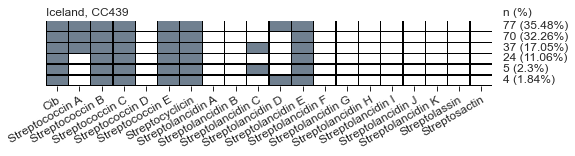

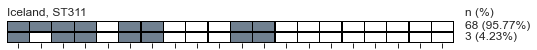

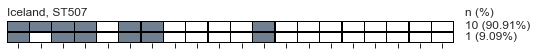

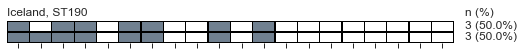

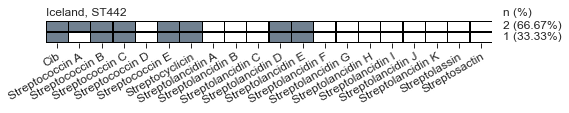

In [38]:

analysis.CC439_hm(df)

#### Figure 4D: CC5902 in Kenyan dataset

{'cc5902': <Figure size 576x172.8 with 1 Axes>,
 'st5370': <Figure size 576x57.6 with 1 Axes>,
 'st840': <Figure size 576x28.8 with 1 Axes>,
 'st2052': <Figure size 576x28.8 with 1 Axes>,
 'st5902': <Figure size 576x28.8 with 1 Axes>,
 'st15056': <Figure size 576x28.8 with 1 Axes>}

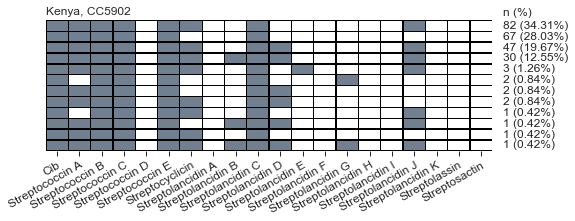

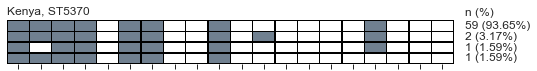

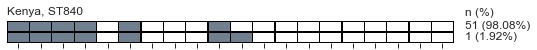

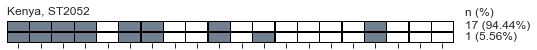

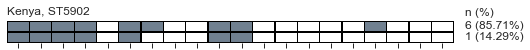

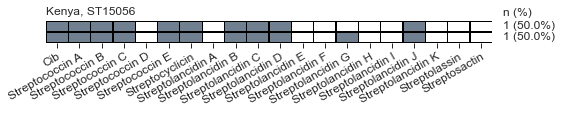

In [39]:
analysis.CC5902_hm(df)

___
___

# Full set of exports 

* Run the below cell to generate a full set of figures and table exports with today's date 

## Setting the date and output directory

In [42]:
d1 = date.today().strftime("%Y%m%d")
output_dir = "./outputs/"

## Exporting data

* Data should be df 
* output_dir and date can be modified above if required 
* Takes a few minutes and spits out a lot of figures at the end 
* Requires an output directory with the following subdirectories:
* outputs/bacteriocin_lineage_tables/dataset
* outputs/bacteriocin_lineage_tables/vaccination_disease
* outputs/bacteriocin_serotype_tables
* outputs/heatmaps/Top10
* outputs/heatmaps/cc439
* outputs/heatmaps/cc5902

/opt/anaconda3/envs/baseenv/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:3356: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf["stack_count"] = stack_count
/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:3357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

Saving csvs to ./outputs//bacteriocin_lineage_tables/dataset/20220607_
saved csv for cib
saved csv for sca
saved csv for scb
saved csv for scc
saved csv for scd
saved csv for sce
saved csv for scy
saved csv for sla
saved csv for slb
saved csv for slc
saved csv for sld
saved csv for sle
saved csv for slf
saved csv for slg
saved csv for slh
saved csv for sli
saved csv for slj
saved csv for slk
saved csv for sls
saved csv for ssa


/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:2419: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0, 0, 5, 10, 15])
/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:2471: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels([0, 5, 10])


Saved csv for cib in Iceland
Saved csv for sca in Iceland
Saved csv for scb in Iceland
Saved csv for scc in Iceland
Saved csv for scd in Iceland
Saved csv for sce in Iceland
Saved csv for scy in Iceland
Saved csv for sla in Iceland
Saved csv for slb in Iceland
Saved csv for slc in Iceland
Saved csv for sld in Iceland
Saved csv for sle in Iceland
Saved csv for slf in Iceland
Saved csv for slg in Iceland
Saved csv for slh in Iceland
Saved csv for sli in Iceland
Saved csv for slj in Iceland
Saved csv for slk in Iceland
Saved csv for sls in Iceland
Saved csv for ssa in Iceland
Saved csv for cib in Kenya
Saved csv for sca in Kenya
Saved csv for scb in Kenya
Saved csv for scc in Kenya
Saved csv for scd in Kenya
Saved csv for sce in Kenya
Saved csv for scy in Kenya
Saved csv for sla in Kenya
Saved csv for slb in Kenya
Saved csv for slc in Kenya
Saved csv for sld in Kenya
Saved csv for sle in Kenya
Saved csv for slf in Kenya
Saved csv for slg in Kenya
Saved csv for slh in Kenya
Saved csv for s

/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:2681: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=12)
/Users/madeleinebutler/Desktop/PhD/Bacteriocins/analysis/thesis_code/narwhal/analysis.py:2705: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plot, (ax1) = plt.subplots(1, figsize=(8, height))


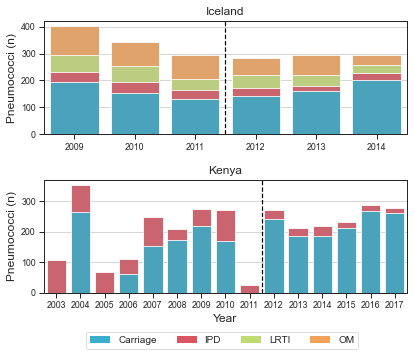

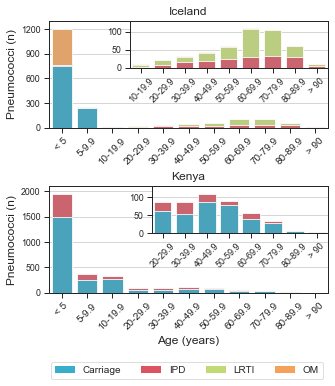

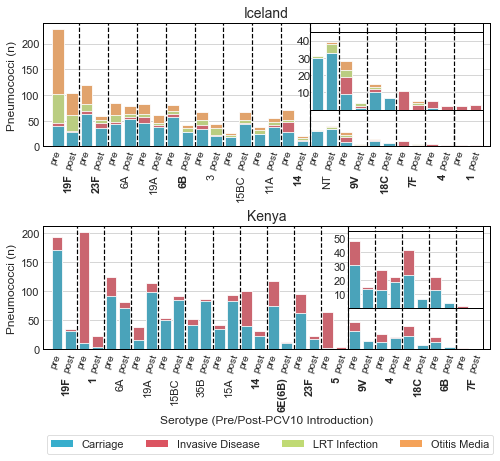

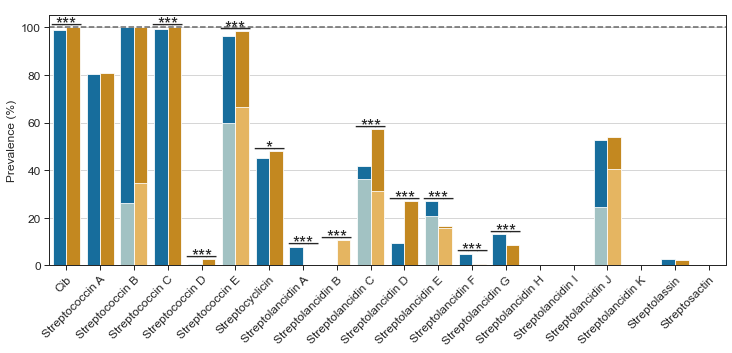

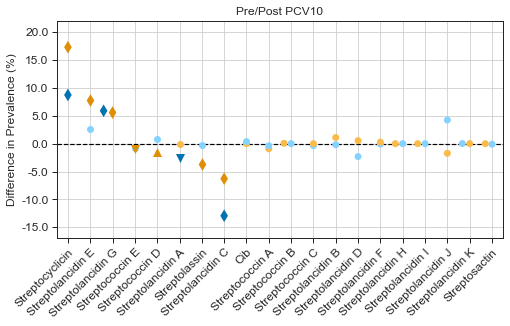

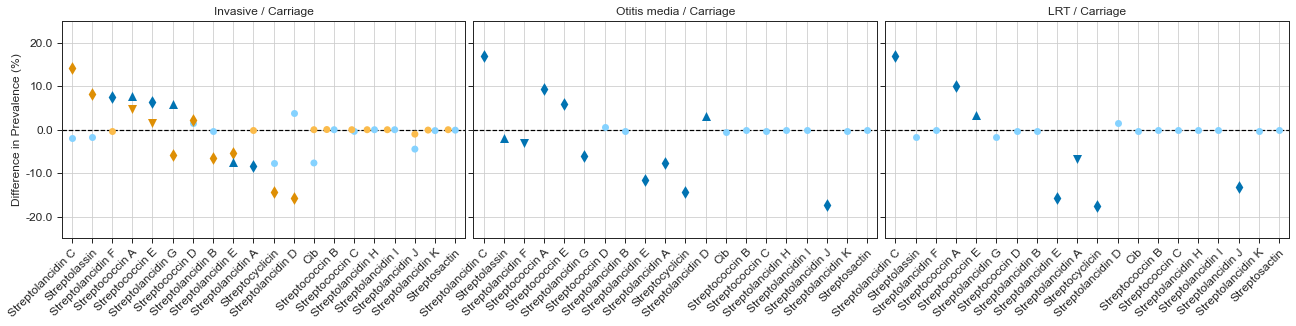

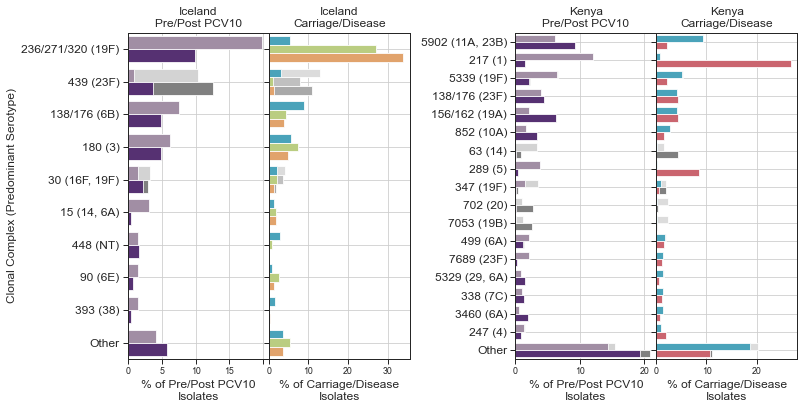

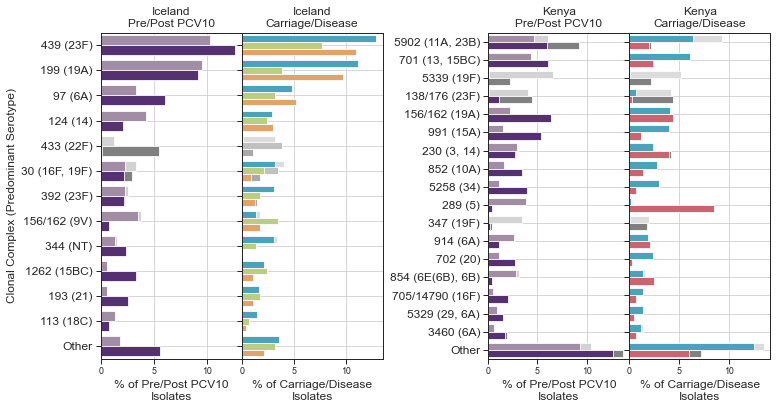

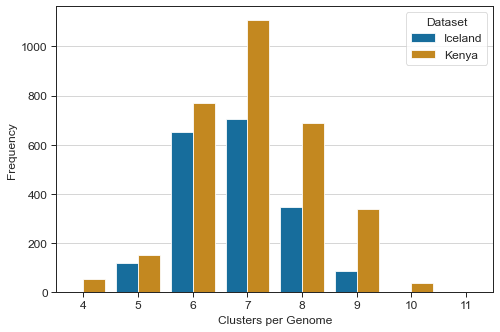

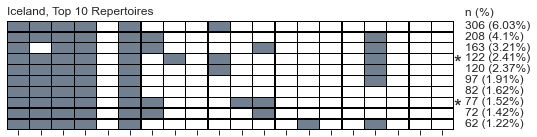

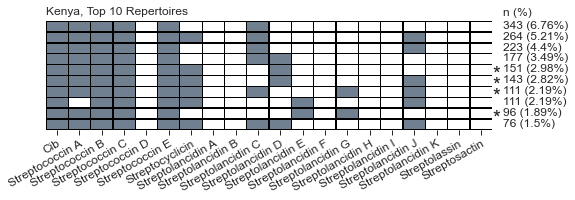

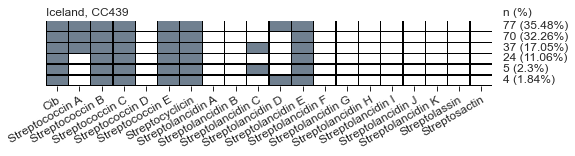

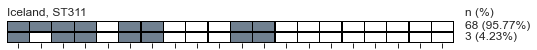

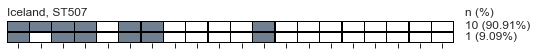

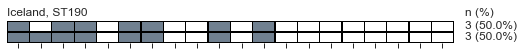

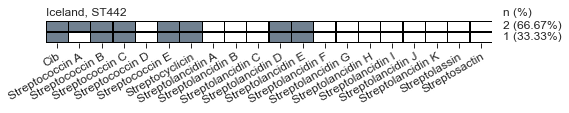

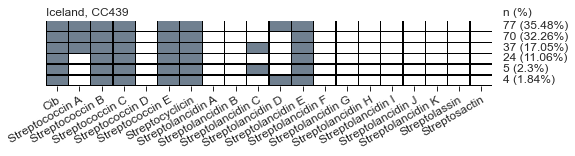

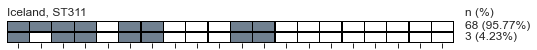

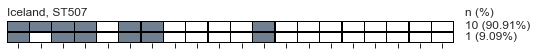

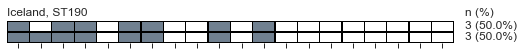

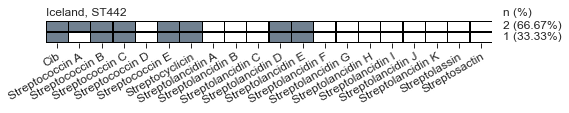

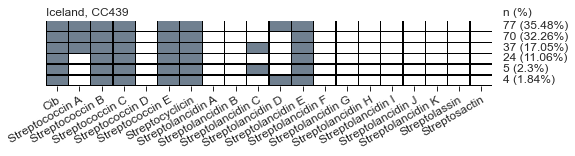

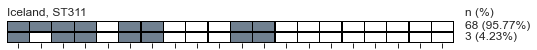

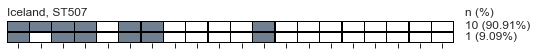

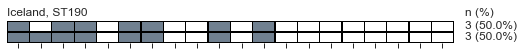

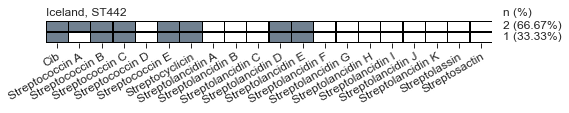

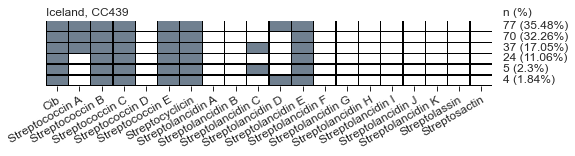

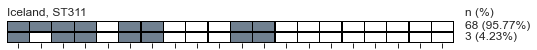

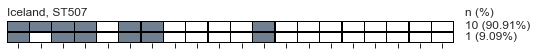

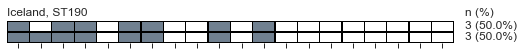

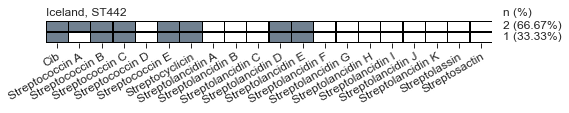

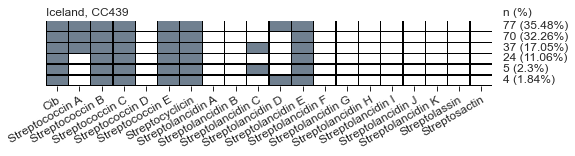

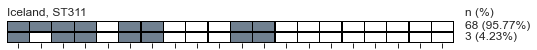

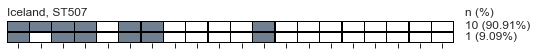

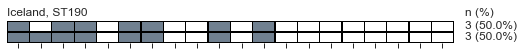

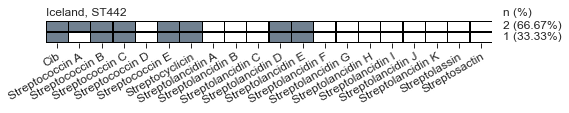

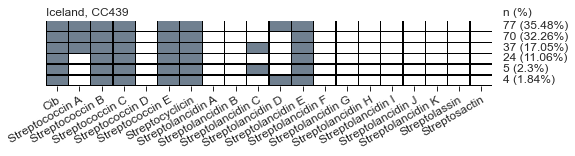

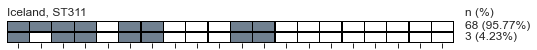

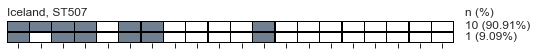

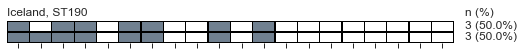

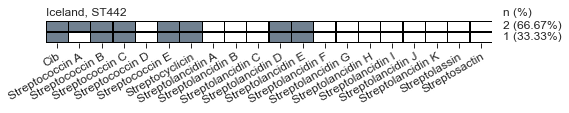

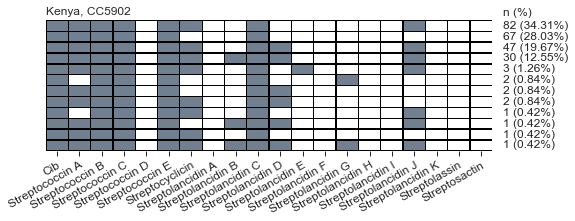

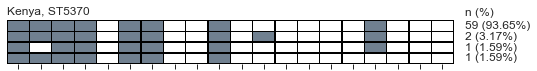

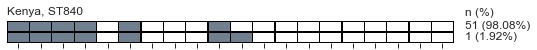

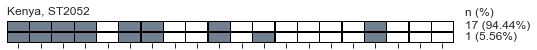

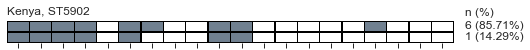

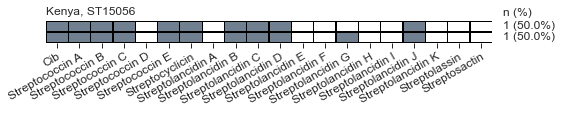

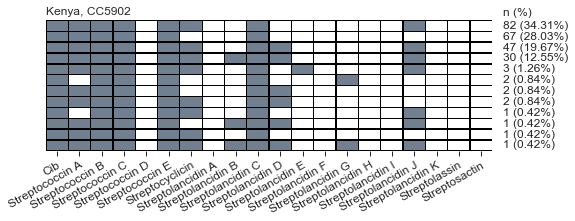

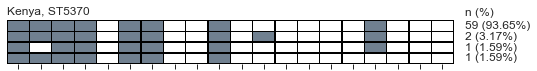

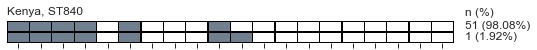

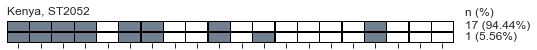

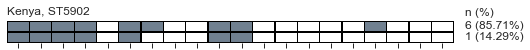

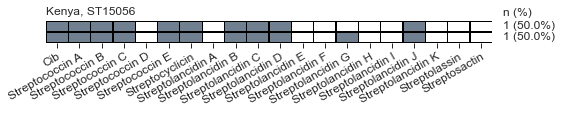

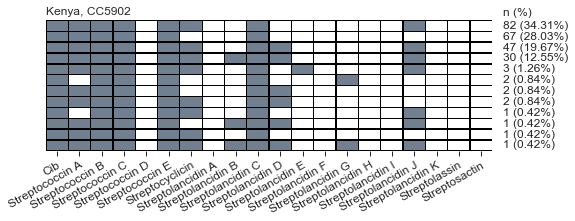

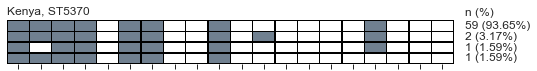

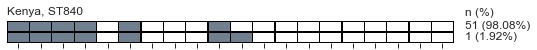

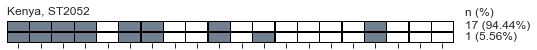

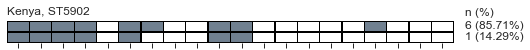

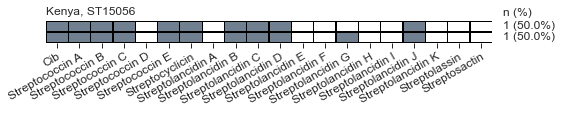

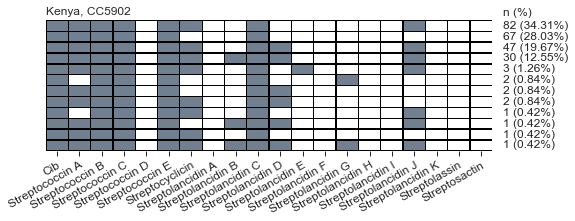

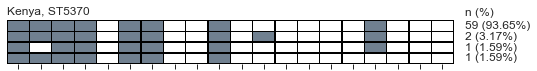

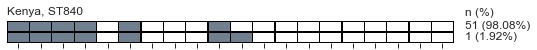

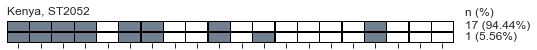

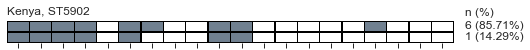

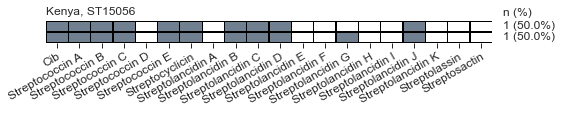

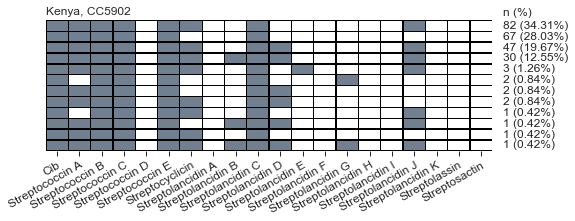

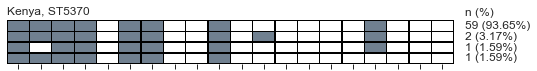

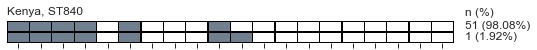

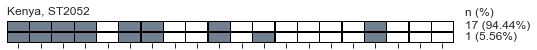

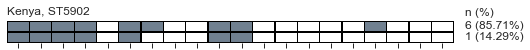

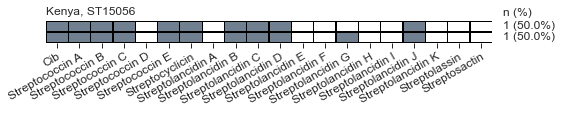

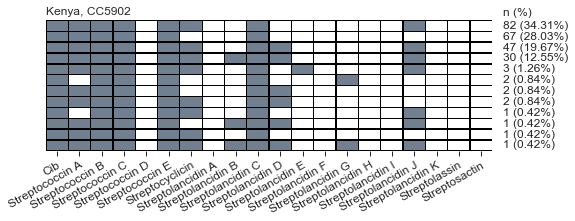

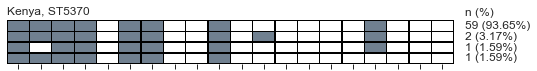

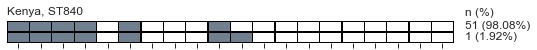

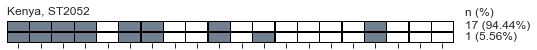

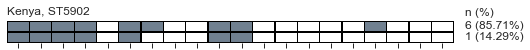

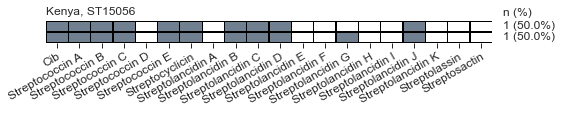

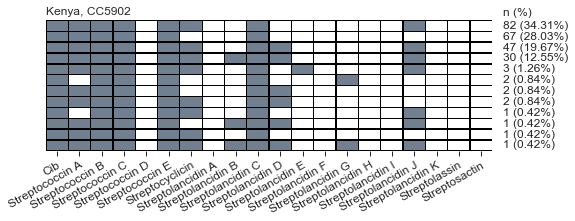

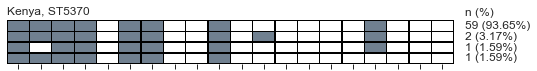

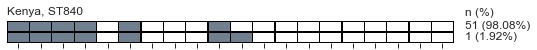

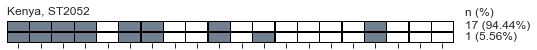

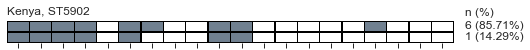

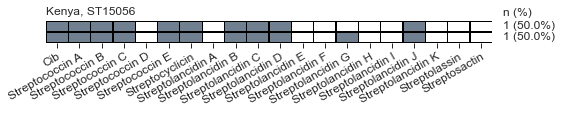

In [70]:
reload(analysis)
def full_export(data, d1, output_dir):

    output = output_dir + d1 + "_"

    analysis.summary_table(data).to_csv((output + "dataset_summary.csv"))
    
    analysis.cc_freq_proc(df[df.country == "Iceland"], 20).to_csv((output + "Iceland_topCCs.csv"))
    analysis.cc_freq_proc(df[df.country == "Kenya"], 20).to_csv((output + "Kenya_topCCs.csv"))

    analysis.serotype_freq_proc(df[df.country == "Iceland"], 20).to_csv((output + "Iceland_topSerotypes.csv"))
    analysis.serotype_freq_proc(df[df.country == "Kenya"], 20).to_csv((output + "Kenya_topSerotypes.csv"))

    analysis.stack_year_plot(df).savefig((output + "year_plot.svg"), format='svg', dpi=1200, bbox_inches='tight')

    analysis.age_plot(df).savefig((output + "age_plot.svg"), format='svg', dpi=1200, bbox_inches='tight')

    analysis.stacked_serotype(df).savefig((output + "serotype_plot.svg"), format='svg', dpi=1200, bbox_inches='tight')

    analysis.supp_table_5_6(df).to_csv((output + "cluster_composition.csv"))

    analysis.grouped_prev_bar(df).savefig((output + "bacteriocin_prevalence.svg"), format='svg', dpi=1200, bbox_inches='tight')

    analysis.scatter_vac(df).savefig((output + "bacteriocin_vac.svg"), format='svg', dpi=1200, bbox_inches='tight')

    analysis.scatter_dis_panel(df, "").savefig((output + "bacteriocin_cardis.svg"), format='svg', dpi=1200, bbox_inches='tight')

    analysis.location_cc_assocations(df, (output_dir + "/bacteriocin_lineage_tables/dataset/" + d1 + "_"))

    analysis.slc_panel(df).savefig((output + "slc_cc.svg"), format='svg', dpi=1200, bbox_inches='tight')

    analysis.scy_panel(df).savefig((output + "scy_cc.svg"), format='svg', dpi=1200, bbox_inches='tight')

    analysis.bacteriocin_cc_table_combo_outputs(df, "Iceland", (output_dir + "bacteriocin_lineage_tables/vaccination_disease/" + d1)) 
    analysis.bacteriocin_cc_table_combo_outputs(df, "Kenya", (output_dir + "bacteriocin_lineage_tables/vaccination_disease/" + d1)) 
    
    analysis.bacteriocin_serotype_table_outputs(df[df.country == "Iceland"], (output_dir + "bacteriocin_serotype_tables/" + d1 + "_Iceland"))
    analysis.bacteriocin_serotype_table_outputs(df[df.country == "Kenya"], (output_dir + "bacteriocin_serotype_tables/" + d1 + "_Kenya"))  

    analysis.cluster_count_bar(df).savefig((output + "cluster_count.svg"), format='svg', dpi=1200, bbox_inches='tight')
    
    for position,fig in enumerate(analysis.top10rep_hm(df)):
        if position == 0:
            fig.savefig((output_dir  + "heatmaps/Top10/" + d1 + "Iceland_top_10_rep.svg"), format='svg', dpi=1200, bbox_inches='tight')
        elif position == 1:
            fig.savefig((output_dir + "heatmaps/Top10/" + d1 + "Kenya_top_10_rep.svg"), format='svg', dpi=1200, bbox_inches='tight')

    analysis.lineage_rep_table(df[df.country == "Iceland"]).to_csv((output + "Iceland_repertoire_lineage.csv"))

    analysis.lineage_rep_table(df[df.country == "Kenya"]).to_csv((output + "Kenya_repertoire_lineage.csv"))

    for fig in analysis.CC439_hm(df):

        analysis.CC439_hm(df)[fig].savefig((output_dir  + "heatmaps/cc439/" + d1 + fig), format='svg', dpi=1200, bbox_inches = "tight")

    for fig in analysis.CC5902_hm(df):

        analysis.CC5902_hm(df)[fig].savefig((output_dir  + "heatmaps/cc5902/" + d1 + fig), format='svg', dpi=1200, bbox_inches = "tight")

full_export(df, d1, output_dir)
    


___
___

## ChiSq sanity checks



In [40]:
analysis.chisq_proc_dataset(df)

,O1,O2,O3,O4
cib,1895,3159,17,0
sca,1537,2559,375,600
scb,1912,3158,0,1
scc,1896,3159,16,0
scd,9,85,1903,3074
sce,1840,3115,72,44
scy,862,1523,1050,1636
sla,152,8,1760,3151
slb,2,338,1910,2821
slc,798,1805,1114,1354


In [41]:
analysis.chisq(analysis.chisq_proc_dataset(df))

,chisq_result
cib,P < 0.001
sca,NS
scb,LowN
scc,P < 0.001
scd,P < 0.001
sce,P < 0.001
scy,P < 0.05
sla,P < 0.001
slb,P < 0.001
slc,P < 0.001
